In [22]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

- **Autoregressive Models**: Models that regress the value of a signal on the previous valies of that same signal are naturally called auto-regressive models

- **Latent Autogressive**: Models that regress the value of a signal on fixed length sequence of previous value in addition to a summary of the whole sequence until then stored in a hidden state
- **Language models** and more generally **sequence models** are estimator function which takes a sequence (E.g a sequnce of tokens or words in language) and estimate the joint probability of the entire sequence

- **Markov condition**: In sequence data, when ever we can discard the history beyond k-steps without a loss in information, we say the sequence is a k-th order Markov model. If k=1, it means that we just need 1 past observation to correctly infer the next step without considering the whole sequence. Eventhough this always an approximation, we see it as a good compromise for both computational cost and reducing marginal returns


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [23]:
class Data(d2l.DataModule):
    """Generate data points following the sine curve but with some noise"""

    def __init__(self, batch_size=16, T=1000, num_train=600, tau=8):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

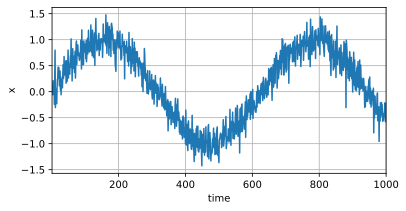

In [24]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[ 1,1000], figsize=(6,3))

In [25]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    """
    Our features are the x_t = X[t-1, ... t-tau] which are the past observations.
    The label y_t = X[t]
    """
    # We have an array of tau-lengthed array
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    X = torch.tensor([1,2]).reshape()

    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau :].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

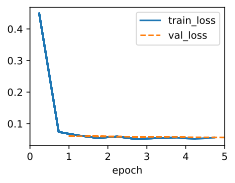

In [26]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

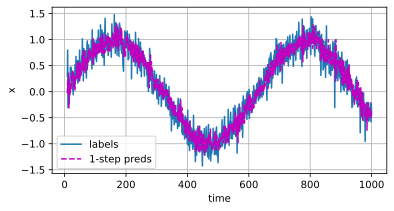

In [27]:
# We evaluate how the model compares with our trained data
onestep_predictions = model(data.features).detach().numpy()
d2l.plot(
    data.time[data.tau :],
    [data.labels, onestep_predictions],
    "time",
    "x",
    legend=["labels", "1-step preds"],
    figsize=(6, 3),
)

In [28]:
# In this case, from the 605 prediction, we use the last tau prediction as the features and so on for the 606, 607 etc
multistep_predictions = torch.zeros(data.T)
multistep_predictions[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_predictions[i] = model(
        multistep_predictions[i - data.tau : i].reshape((1, -1))
    )
multistep_predictions = multistep_predictions.detach().numpy()

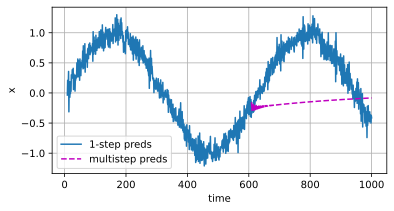

In [29]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
[onestep_predictions, multistep_predictions[data.num_train+data.tau:]], 'time',
'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

In [30]:
def k_step_pred(k):
    """ """
    features = []
    """ We use only the first k  """
    for i in range(data.tau):
        features.append(data.x[i : i + data.T - data.tau - k + 1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i + data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau :]

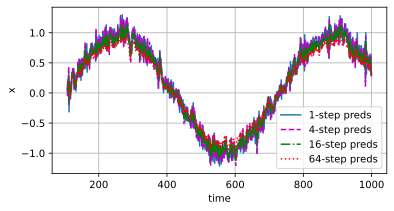

In [31]:
steps = (1, 4, 16, 64, 100)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
[preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

## Exercises 
1. As tau increases, the k_step_prediction gets better but gradually out of phase. I think 8 is good

2. If there was no noise, we will need the following: 